# Ifood DA Challenge

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from pandas_profiling import ProfileReport
from plotly.offline import iplot
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [116]:
%matplotlib inline

## Data Exploration
Always the first thing I do is explore the data to know what I'm dealing with, what are the challenges, and the steps needed!\
In this challenge I chose to use **pandas** to do the data exploration cause I think is an easy-to-use library but still powerful.

The first step before any data exploration is to read the .CSV file.

In [117]:
# reading .csv file
customer_survey_df = pd.read_csv('/home/nicholas/repos/ifood_da_challenge/ml_project1_data.csv')

The best thing to do now is check the data, and for that, I'm using **pandas profiling**, a good facilitator for that first look.

In [118]:
customer_survey_df_profile = ProfileReport(customer_survey_df, title="Pandas Profiling Report", minimal=True)

customer_survey_df_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

For a more summarized view I'm also printing general information about the **dataframe**.

In [119]:
# verifying data types
print(customer_survey_df.dtypes, "\n")

# verifying number o rows and columns
print(customer_survey_df.shape, "(rows, columns)\n")

# cheking the percentege of null values
for column in customer_survey_df.columns:
    percentage = customer_survey_df[column].isnull().mean()
    print(f'{column}: {round(percentage*100, 2)}%')

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object 

(2240, 29) (rows, columns)

ID: 0.0%
Year_Birth: 0.0%
Education: 0.0%
Marital_Status:

After checking the **dataframe**, was seen there is some missing data, knowing that, I chose the mean method to replace them, avoiding missing more data.

In [120]:
# replacing missing values by the mean
customer_survey_df['Income'].fillna(customer_survey_df['Income'].mean(), inplace=True)

### Data cleaning
A part of the data exploration, is cleaning it and this can be done in several ways, such as the following:

**Outliers** are unusual values in the **dataset**, and they can distort statistical analysis which is bad for **ML models**. With that in mind, I'm using boxplots to check for **outliers**.

In [121]:
# defining columns to be checked
outlier_columns = ['Income',
'MntWines',
'MntFruits',
'MntMeatProducts',
'MntFishProducts',
'MntSweetProducts',
'MntGoldProds',
'NumDealsPurchases',
'NumWebPurchases',
'NumCatalogPurchases',
'NumStorePurchases',
'NumWebVisitsMonth']

# plotting boxplots
for column in outlier_columns:
    print(column + ':')
    fig = go.Figure()
    fig.add_box(x=customer_survey_df[column], text=customer_survey_df[column])
    iplot(fig)

Income:


MntWines:


MntFruits:


MntMeatProducts:


MntFishProducts:


MntSweetProducts:


MntGoldProds:


NumDealsPurchases:


NumWebPurchases:


NumCatalogPurchases:


NumStorePurchases:


NumWebVisitsMonth:


After analyzing the **outliers**, we can see there is a lot of then and if I removed them all, there would be a great data loss, so I decided to remove only the **strong outliers**.

**Outliers** are defined as: $$ Q1 - 1.5(IQR) > Outlier > Q3 + 1.5(IQR) $$
**Strong outliers** are the same but multiplied by 3: $$ Q1 - 3.0(IQR) > StrongOutlier > Q3 + 3.0(IQR) $$

In [122]:
# identyfing strong outliers
for column in outlier_columns:
    print("Upper outer fence value for " + column + ':', int(customer_survey_df[column].mean() + 3*customer_survey_df[column].std()))

Upper outer fence value for Income: 127360
Upper outer fence value for MntWines: 1313
Upper outer fence value for MntFruits: 145
Upper outer fence value for MntMeatProducts: 844
Upper outer fence value for MntFishProducts: 201
Upper outer fence value for MntSweetProducts: 150
Upper outer fence value for MntGoldProds: 200
Upper outer fence value for NumDealsPurchases: 8
Upper outer fence value for NumWebPurchases: 12
Upper outer fence value for NumCatalogPurchases: 11
Upper outer fence value for NumStorePurchases: 15
Upper outer fence value for NumWebVisitsMonth: 12


In [123]:
# removing strong outliers
for column in outlier_columns:
    customer_survey_df.drop(customer_survey_df[customer_survey_df[column]>(int(customer_survey_df[column].mean() + 3*customer_survey_df[column].std()))].index, inplace=True)

Post **outliers** removal, now I'm making the text normalization which is another important step of the **data cleaning**.\
Here I'm removing spaces, numbers, and passing the column values to lowercase.

In [124]:
# Text Normalization

customer_survey_df_str = list(customer_survey_df.select_dtypes(include = 'object').columns.values)

for i in customer_survey_df_str:
    customer_survey_df[i].str.lower()
    customer_survey_df[i].str.strip()
    customer_survey_df[i].replace('[^\w\s]', '', regex=True, inplace=True)

Now the text is normalized I'll keep on cleaning.\
In this part, I'm checking for weird text values, and if there is any I'll remove then.

In [125]:
# searching weird texts

print(customer_survey_df['Education'].unique())

print(customer_survey_df['Marital_Status'].unique())

['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'YOLO']


In [126]:
# Removing weird texts

customer_survey_df.drop(customer_survey_df[customer_survey_df.Marital_Status == 'YOLO'].index, inplace=True)
customer_survey_df.drop(customer_survey_df[customer_survey_df.Marital_Status == 'Alone'].index, inplace=True)
customer_survey_df.drop(customer_survey_df[customer_survey_df.Marital_Status == 'Absurd'].index, inplace=True)

Weird texts removed, now I'll verify if the data is balanced.

In [127]:
# Verifying the data balance

# class count
class_count_0, class_count_1 = customer_survey_df['Response'].value_counts()

# Separate class
class_0 = customer_survey_df[customer_survey_df['Response'] == 0]
class_1 = customer_survey_df[customer_survey_df['Response'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (1647, 29)
class 1: (216, 29)


As we can see the **dataframe** is really unbalanced which normally is a bad thing for **ML**, but with this amount of data if I **oversample** it will probably be **overfitted** and if I **undersample** it there wouldn't be sufficient data for an efficient model. So in this case I intend to use a **stratified** function, that can handle this better.

After all that it's time to make the **correlation graphic**. It is really useful to highlight the highly correlated values.

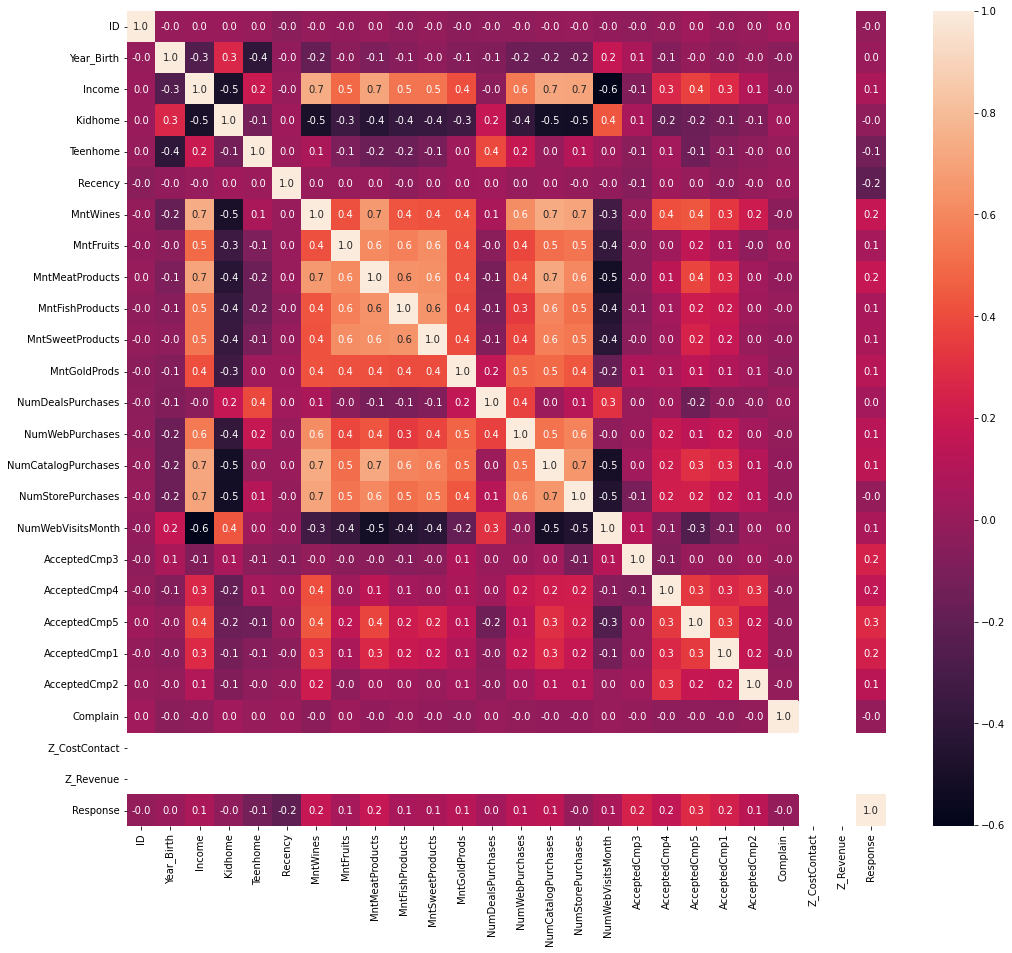

In [128]:
# ploting correlation graphic
correlation_matrix = customer_survey_df.corr()
plt.figure(figsize = (17, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = ".1f")

With the **correlation graphic**, we can see there are two non identified and useless columns, so I'm removing then.

In [129]:
# removing Z columns
customer_survey_df.drop('Z_CostContact', axis = 1, inplace=True)
customer_survey_df.drop('Z_Revenue', axis = 1, inplace=True)

And now we have the correct **correlation graphic!**

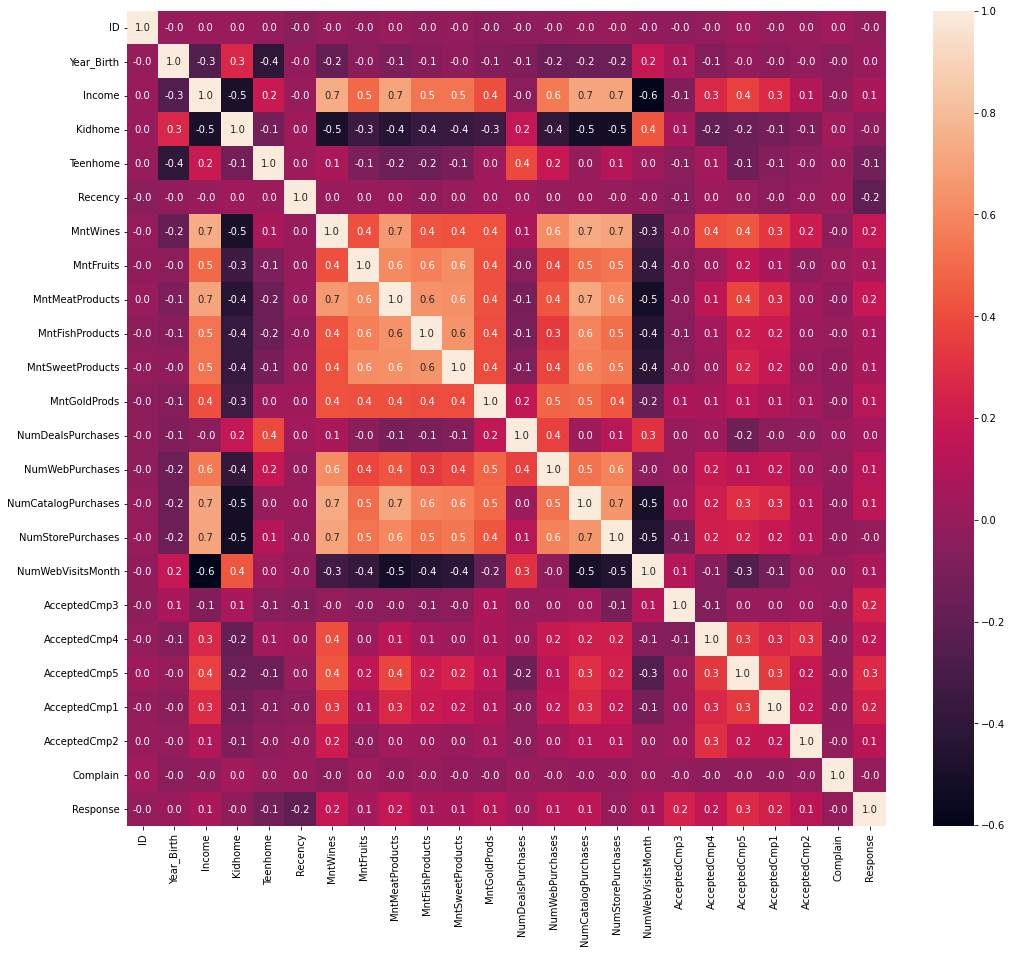

In [130]:
correlation_matrix = customer_survey_df.corr()
plt.figure(figsize = (17, 15))
sns.heatmap(correlation_matrix, annot = True, fmt = ".1f")

## Machine Learning
With all the **data exploration** done I can start the **ML** part, the most fun! =)

Based on this case objective, which is to produce the highest profit for the next marketing campaign, the best metric is ****precision**** rather than recall or overall accuracy.
**Precision** returns what proportion of positive identifications was actually correct as follows:
$$
\frac {Tp}{Tp + Fp}
$$
With this, the campaign can be a lot more **assertive** and **less expensive**, sending it only to the people intending to buy the gadget.

To start building the **models** the first thing to do is define the answer column, which in this case is the column that informs whether or not the consumer participated in the pilot campaign, and also defines all the **resources** that can be used in the models.

In [131]:
# defining Y as the answer column
Y = customer_survey_df['Response'].values

# defining all usable features
features = [
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain'
 ]

In this dataframe we have some categorical variables so it's necessary to transform them into numeric variables before training the models.\
**Pandas** has an easy way to make that transformation with the `get_dummies` function.

In [132]:
# Tranforming dataframe
dummies_customer_survey_df = pd.get_dummies(customer_survey_df[features])

Choosing the best **features** for the models is a hard task, therefore I'm using the **SelectKBest** function.\
This Function select the *K* features based on the *chi²* that calculates the highest score with statistical tests.

I've made some tests and the best results were with *k=10* features. 

In [133]:
# selecting best features
select_KBest = SelectKBest(chi2, k = 10)
select_KBest.fit(dummies_customer_survey_df, Y)
train_kbest = select_KBest.transform(dummies_customer_survey_df)

As I said before in this case I'm using a stratified function, more specific the **StratifiedKFold**.\
This function sets the split strategy for the dataset and in how many parts it will be split preserving the percentage of samples for each class, making the results more reliable.

Just like the **SelectKBest** function I've made tests and concluded that *n=5* brings the best results.

In [134]:
# Stratifying data
cv = StratifiedKFold(n_splits = 5, shuffle=True)

There are other two very important functions that improve the models precision, **Pipeline** and **Cross-Validate**.

Basically, **Pipeline** is a set of data processing elements connected in series, where the output of one element is the input of the next one.\
The purpose of the pipeline here is to assemble the steps that can be **Cross-Validated** together.

And last but not least is the `cross_validate` function, which works directly with the **StratifiedKFold** and **Pipeline** functions. Is a technique for evaluating the generalizability of a model from a dataset.\
The concept of **Cross-validate** is partitioning the dataset into exclusive subsets and using some of these subsets for training the model parameters and making the tests with the remaining subsets. As previously defined the StratifiedKFold is been used as the split strategy.

I'm setting a seed so that everyone can reproduce the same results.

In [135]:
SEED = 403454
np.random.seed(SEED)

### Models

Instead of simply choosing a model, I decided to test the 5 most common ones to see which one performs better in this case!

#### Decision Tree Classifier

**Decision tree** is one of the predictive modelling approaches used in statistics and machine learning. It uses a **decision tree** to go from observations about an item to conclusions about the item's target value. In these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels.

In [136]:
# DecisionTreeClassifier
model_DTC = DecisionTreeClassifier(max_depth=3)

pipeline = Pipeline([('DTC', model_DTC)])

prediction_DTC = cross_validate(pipeline, train_kbest, Y, cv = cv, return_train_score=False, scoring = ['precision_macro'])

#### Support-vector Machine (SVM)

In machine learning, **support-vector machines** are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis. Here I'm using **Support Vector Classification (SVC)**

The **SVC** model needs the `StandardScaler()` function to work properly.\
What the `StandardScaler()` function does is standardize features by removing the mean and scaling to unit variance.

In [137]:
# SVC
model_SVC = SVC()

scaler = StandardScaler()

pipeline = Pipeline([('scaler', scaler), ('SVC', model_SVC)])

prediction_SVC = cross_validate(pipeline, train_kbest, Y, cv = cv, return_train_score=False, scoring = ['precision_macro'])

#### Logistic regression

**Logistic regression** is a statistical model that basically uses a logistic function to model a binary dependent variable. Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail which is represented by an indicator variable, where the two values are labeled "0" and "1", aka classes.

In [138]:
# LogisticRegression
model_LR = LogisticRegression(max_iter=1000)

pipeline = Pipeline([('LR', model_LR)])

prediction_LR = cross_validate(pipeline, train_kbest, Y, cv = cv, return_train_score=False, scoring = ['precision_macro'])

#### Naive Bayes classifier

In statistics, **naive Bayes classifiers** are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features.

In [139]:
# GaussianNB
model_NB = GaussianNB()

pipeline = Pipeline([('NB', model_NB)])

prediction_NB = cross_validate(pipeline, train_kbest, Y, cv = cv, return_train_score=False, scoring = ['precision_macro'])

#### K-Nearest Neighbors

The **K-Nearest Neighbors (K-NN)** is a non-parametric classification method, it can be used for classification and regression. In both cases, the input consists of the *K* closest training examples in a data set.

For classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its *K* nearest neighbors. If *K=1*, then the object is simply assigned to the class of that single nearest neighbor.

In [140]:
# KNeighborsClassifier
model_KNN = KNeighborsClassifier(n_neighbors=4)

pipeline = Pipeline([('K-NN', model_KNN)])

prediction_KNN = cross_validate(pipeline, train_kbest, Y, cv = cv, return_train_score=False, scoring = ['precision_macro'])

Now with all models trained let's print the results to see which one is the best.\
A simple print won't do the trick so I'm creating a function to print the two metrics I want, **mean** and **range**.

In [141]:
# defining the print result function
def print_model_results(results):
  mean = results['test_precision_macro'].mean()
  standard_deviation = results['test_precision_macro'].std()
  print("Average Precision: %.2f" % (mean * 100))
  print("Standard Deviation: %.2f" % (standard_deviation * 100))
  print("Precision Range: [%.2f, %.2f]" % ((mean - 2 * standard_deviation) * 100, (mean + 2 * standard_deviation) * 100))

In [142]:
ML_models = {
"DTC:" : prediction_DTC,
"SVC:" : prediction_SVC,
"LR:" : prediction_LR,
"NB:" : prediction_NB,
"K-NN:": prediction_KNN
}

# printing results
for model in ML_models:
    print(model)
    print_model_results(ML_models.get(model))

DTC:
Average Precision: 79.87
Standard Deviation: 4.28
Precision Range: [71.31, 88.43]
SVC:
Average Precision: 79.41
Standard Deviation: 7.41
Precision Range: [64.59, 94.24]
LR:
Average Precision: 70.43
Standard Deviation: 7.69
Precision Range: [55.06, 85.81]
NB:
Average Precision: 57.43
Standard Deviation: 3.51
Precision Range: [50.40, 64.45]
K-NN:
Average Precision: 69.61
Standard Deviation: 12.95
Precision Range: [43.71, 95.52]


The test shows that **DTC** and **SVC** are the best models for this case.\
Although the average precision of the **DTC** is just a tad better, its standard deviation is a lot better, and the confidence interval is a lot smaller, making it the best choice to improve the next marketing campaign profit!

Now that all code part is done, it's time to start the BI part, which I'll do it using Power BI, so I need to export the data to a .CSV file.

In [143]:
customer_survey_df.to_csv('clean_customer_survey_df.csv', index=False)

See you later! =)